# Nurse Scheduling Problem Using Qiskit

<div style="text-align: center">
    <img src = "../../Images_Opt/close-up-medical-team-ready-work.jpg" alt="close-up-medical-team-ready-work" 
    style="width: 450px; height: 300px;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
    </p>
</div>

Pic: [freepik](https://www.freepik.com/free-photo/close-up-medical-team-ready-work_19868049.htm#from_element=detail_alsolike)

<div style="display: flex; justify-content: center; gap: 20px;">
    <img src="../../Images_Opt/cplex.png" 
         alt="cplex" 
         style="width: 225px; height: 150px;">
    <img src="../../Images_Opt/NumPyMinimumEigensolver.png" 
         alt="NumPyMinimumEigensolver" 
         style="width: 225px; height: 150px;">
    <img src="../../Images_Opt/QAOA.png" 
         alt="QAOA" 
         style="width: 225px; height: 150px;">
</div>

## Introduction

The **Nurse Scheduling Problem (NSP)** involves creating fair and efficient work schedules while meeting hospital demands, legal constraints, and nurse preferences. It balances staffing needs with employee well-being to ensure quality patient care. Solving NSP efficiently reduces burnout, improves job satisfaction, and enhances overall healthcare system performance and efficiency.

## Method

### Objective function

In the **Nurse Scheduling Problem (NSP)**, we define a binary variable $x_{n,d} \in \{0,1\}$ for every possible nurse scheduling scenario, where:

*   $n$ represents each nurse, where $n \in \{1, \dots, N\}$.
*   $d$ represents the day a nurse is scheduled to be on duty, where $d \in \{1, \dots, D\}$.

The problem can be formulated as the following optimization problem:
$$
\min \sum_{n=1}^{N} \sum_{d=1}^{D} x_{n,d}
$$
However, this objective function is not in quadratic form. To ensure that the workload is evenly distributed among nurses, we introduce a **penalty term** $\frac{D}{N}$ to encourage a balanced assignment. Thus, we redefine our objective function as:
$$
\min \sum_{n=1}^{N} \left( \sum_{d=1}^{D} x_{n,d} - \frac{D}{N} \right)^{2}
$$
This quadratic formulation ensures that each nurse has a workload close to $\frac{D}{N}$, promoting fairness in day assignments.

### Constraint



Then we have to impose constraints to ensure a feasible schedule. 
1.  Nurse constraint (Hard constraint): Each day must have at least one nurse working. We can have  
    $$
    \sum_{n}^{D} x_{n,d} \geq 1, \ n\in \{1,\cdots,N\}, \ d\in \{1,\cdots,D\}
    $$
2.  Day constraint (Soft Constraint): No nurse should work two or more consecutive days
    $$
    x_{n,d} + x_{n, d+1} \leq 1, \ n\in \{1,\cdots,N\}, \ d\in \{1,\cdots,D\}
    $$
3.  Workload (Soft constraint): define average workload as $D/N$ and apply it as a penalty term to make our problem a quadratic problem.

The final form of our **Nurse Scheduling Problem (NSP)** probelm can be represented as 
$$
\begin{array}{ll}
\text{minimize} & \sum_{n=1}^{N}\bigg( \sum_{d=1}^{D} x_{n,d} - \frac{D}{N} \bigg)^{2}\\
\text{subject to} & \sum_{n}^{D} x_{n,d} \geq 1, \forall \ N, \forall \ D\\
& x_{n,d} + x_{n, d+1} \leq 1, \forall \ N, \forall \ D\\
\end{array}
$$

## Python Workflow  

Here's our workflow to solve the **Nurse Scheduling Problem (NSP)**. To better demonstrate how to apply the **quantum algorithm (QAOA)** and compare it with the exact solver and classical solver in **DOcplex**, we will simplify our problem and only consider a **1-shift scenario, 2 nurses, and 4 days**. The workflow of this notebook is as follows:  

1. Construct a **Cplex** model for the NSP.  
    *   Solve it using the **Cplex solver**.  
2. Using **Qiskit** fto solve NSP.
    *   Convert the **Cplex** model into a **Qiskit quadratic problem** using the `from_docplex_mp` class from `qiskit_optimization.translators`.  
    *   Ensure the problem is in **QUBO format** using the `QuadraticProgramToQubo` class from `qiskit_optimization.converters`.  
    *   Solve the QUBO using the exact solver `NumPyMinimumEigensolver` from `qiskit_algorithms`.  
    *   Solve the QUBO using the **quantum algorithm** with `QAOA` from `qiskit_algorithms`.  


## Construct a Cplex model for the NSP.  

In [1]:
from docplex.mp.model import Model
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.translators import from_docplex_mp
from qiskit.primitives import Sampler
import numpy as np

In [ ]:
# Create model
mdl = Model("nurse_scheduling")

# Define problem parameters
num_nurses = 2
num_days = 4

In [3]:
# Create binary variables for each nurse and day 
x = {(n,d): mdl.binary_var(name = f"x_{n}_{d}") for n in range(num_nurses) for d in range(num_days)}
#print(x)

In [4]:
# Hard Constraint: Each day must have at least one nurse working
for d in range(num_days):
    mdl.add_constraint(mdl.sum(x[n, d] for n in range(num_nurses)) >= 1, f"daily_coverage_{d}")

In [5]:
# Soft Constraint: No nurse should work two or more consecutive days
for n in range(num_nurses):
    for d in range(num_days-1):
        mdl.add_constraint(mdl.sum(x[n, d] + x[n, d+1]) <= 1, f"consecutive_days_{n}_{d}")

In [6]:
# Soft Constraint: Balance workload among nurses (minimize variance)
avg_workload = num_days / num_nurses
workload = {n: mdl.sum(x[n, d] for d in range(num_days)) for n in range(num_nurses)}

In [7]:
# Define our objective function
mdl.minimize(mdl.sum((workload[n] - avg_workload) ** 2 for n in range(num_nurses)))

### Solve it using the **Cplex solver**.  

In [8]:
# Solve the model
solution = mdl.solve()

schedule_list = []
# Print results
if solution:
    print("Optimal Schedule:")
    for n in range(num_nurses):
        assigned_days = [d for d in range(num_days) if x[n, d].solution_value > 0.5]
        print(f"Nurse {n}: Works on days {assigned_days}")
        # Store the (nurse, assigned_day) pairs as tuples
        for day in assigned_days:
            schedule_list.append((n, day))
else:
    print("No feasible solution found.")


Optimal Schedule:
Nurse 0: Works on days [0, 2]
Nurse 1: Works on days [1, 3]


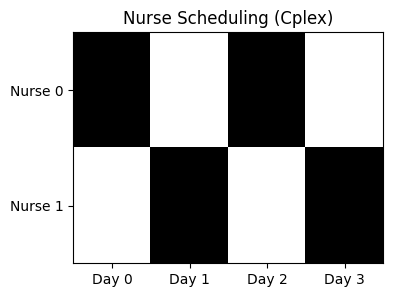

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Given list of tuples (nurse, day)
data = schedule_list #[(0, 0), (0, 2), (1, 1), (1, 3)]

# Create a grid (default: 0 for no shift)
schedule_grid = np.zeros((num_nurses, num_days))

# Fill the grid (1 for assigned shifts)
for nurse, day in data:
    schedule_grid[nurse, day] = 1  # Mark assigned shifts

# Plot the grid
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(schedule_grid, cmap="Greys", aspect="auto")

# Add labels
ax.set_xticks(np.arange(num_days))
ax.set_yticks(np.arange(num_nurses))
ax.set_xticklabels([f"Day {i}" for i in range(num_days)])
ax.set_yticklabels([f"Nurse {i}" for i in range(num_nurses)])

plt.title("Nurse Scheduling (Cplex)")
plt.show()


## Using Qiskit fto solve NSP.

### Convert the Cplex model into a Qiskit quadratic problem

In [10]:
# Load qiskit modules
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 12345

In [11]:
# Load from a Docplex model we just defiend before.
mod = from_docplex_mp(mdl)
print(type(mod))
print()
print(mod.prettyprint())

<class 'qiskit_optimization.problems.quadratic_program.QuadraticProgram'>

Problem name: nurse_scheduling

Minimize
  x_0_0^2 + 2*x_0_0*x_0_1 + 2*x_0_0*x_0_2 + 2*x_0_0*x_0_3 + x_0_1^2
  + 2*x_0_1*x_0_2 + 2*x_0_1*x_0_3 + x_0_2^2 + 2*x_0_2*x_0_3 + x_0_3^2 + x_1_0^2
  + 2*x_1_0*x_1_1 + 2*x_1_0*x_1_2 + 2*x_1_0*x_1_3 + x_1_1^2 + 2*x_1_1*x_1_2
  + 2*x_1_1*x_1_3 + x_1_2^2 + 2*x_1_2*x_1_3 + x_1_3^2 - 4*x_0_0 - 4*x_0_1
  - 4*x_0_2 - 4*x_0_3 - 4*x_1_0 - 4*x_1_1 - 4*x_1_2 - 4*x_1_3 + 8

Subject to
  Linear constraints (10)
    x_0_0 + x_1_0 >= 1  'daily_coverage_0'
    x_0_1 + x_1_1 >= 1  'daily_coverage_1'
    x_0_2 + x_1_2 >= 1  'daily_coverage_2'
    x_0_3 + x_1_3 >= 1  'daily_coverage_3'
    x_0_0 + x_0_1 <= 1  'consecutive_days_0_0'
    x_0_1 + x_0_2 <= 1  'consecutive_days_0_1'
    x_0_2 + x_0_3 <= 1  'consecutive_days_0_2'
    x_1_0 + x_1_1 <= 1  'consecutive_days_1_0'
    x_1_1 + x_1_2 <= 1  'consecutive_days_1_1'
    x_1_2 + x_1_3 <= 1  'consecutive_days_1_2'

  Binary variables (8)
    

### Ensure the problem is in QUBO format

In [12]:
# Convert mod into a QUBO problem
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(mod)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 164.5
Ising Hamiltonian:
SparsePauliOp(['IIIIIIZI', 'IIIIIZII', 'IIZIIIII', 'IZIIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIZIIZ', 'IIIZIIIZ', 'IIIIIZZI', 'IIIIZIZI', 'IIZIIIZI', 'IIIIZZII', 'IZIIIZII', 'ZIIIZIII', 'IIZZIIII', 'IZIZIIII', 'ZIIZIIII', 'IZZIIIII', 'ZIZIIIII', 'ZZIIIIII'],
              coeffs=[-16.25+0.j, -16.25+0.j, -16.25+0.j, -16.25+0.j,  16.75+0.j,   0.5 +0.j,
   0.5 +0.j,  16.25+0.j,  16.75+0.j,   0.5 +0.j,  16.25+0.j,  16.75+0.j,
  16.25+0.j,  16.25+0.j,  16.75+0.j,   0.5 +0.j,   0.5 +0.j,  16.75+0.j,
   0.5 +0.j,  16.75+0.j])


### Solve the QUBO using the exact solver NumPyMinimumEigensolver

In [13]:
# Solve the QUBO using the exact solver `NumPyMinimumEigensolver`
exact_mes = NumPyMinimumEigensolver()
exact_mes = MinimumEigenOptimizer(exact_mes)
exact_result = exact_mes.solve(qubo)
print(exact_result.prettyprint())

objective function value: 0.0
variable values: x_0_0=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=1.0, x_1_0=1.0, x_1_1=0.0, x_1_2=1.0, x_1_3=0.0
status: SUCCESS


In [14]:
# Print results
binary_values = exact_result.x
varaiable_names = exact_result.variable_names

assigned_days = []
if solution:
    print("Optimal Schedule:")
    for value, var in zip(binary_values, varaiable_names):
        if value == 1:
            _, nurse, day = var.split("_")
            assigned_days.append((int(nurse), int(day)))
else:
    print("No feasible solution found.")

schedule = {}
for nurse, day in assigned_days:
    if nurse not in schedule:
        schedule[nurse] = []
    schedule[nurse].append(day)

for nurse, days in schedule.items():
    print(f"Nurse {nurse} works on Days {days}")


Optimal Schedule:
Nurse 0 works on Days [1, 3]
Nurse 1 works on Days [0, 2]


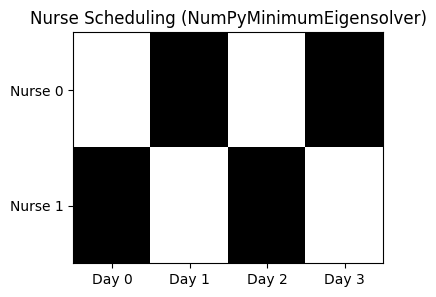

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Given list of tuples (nurse, day)
data = assigned_days #[(0, 1), (0, 3), (1, 0), (1, 2)]

# Create a grid (default: 0 for no shift)
schedule_grid = np.zeros((num_nurses, num_days))

# Fill the grid (1 for assigned shifts)
for nurse, day in data:
    schedule_grid[nurse, day] = 1  # Mark assigned shifts

# Plot the grid
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(schedule_grid, cmap="Greys", aspect="auto")

# Add labels
ax.set_xticks(np.arange(num_days))
ax.set_yticks(np.arange(num_nurses))
ax.set_xticklabels([f"Day {i}" for i in range(num_days)])
ax.set_yticklabels([f"Nurse {i}" for i in range(num_nurses)])

plt.title("Nurse Scheduling (NumPyMinimumEigensolver)")
plt.show()


### Solve the QUBO using the quantum algorithm with QAOA

1. A wrapper for minimum eigen solvers.: `MinimumEigenoptimizer`: [link](https://qiskit-community.github.io/qiskit-optimization/stubs/qiskit_optimization.algorithms.MinimumEigenOptimizer.html)
2. Return type: `MinimumEigenOptimizationResult` [link](https://qiskit-community.github.io/qiskit-optimization/stubs/qiskit_optimization.algorithms.MinimumEigenOptimizationResult.html#qiskit_optimization.algorithms.MinimumEigenOptimizationResult)

In [16]:
# Solve the QUBO using the exact solver `QAOA`
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())
qaoa_mes = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = qaoa_mes.solve(qubo)
print(qaoa_result.prettyprint())


/var/folders/kz/_mr3r3b55qd2r5hd025yvpfw0000gn/T/ipykernel_92250/2972185069.py:2: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())


objective function value: 0.0
variable values: x_0_0=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=1.0, x_1_0=1.0, x_1_1=0.0, x_1_2=1.0, x_1_3=0.0
status: SUCCESS


In [17]:
# Print results
binary_values = qaoa_result.x
varaiable_names = qaoa_result.variable_names

assigned_days = []
if solution:
    print("Optimal Schedule:")
    for value, var in zip(binary_values, varaiable_names):
        if value == 1:
            _, nurse, day = var.split("_")
            assigned_days.append((int(nurse), int(day)))
else:
    print("No feasible solution found.")

schedule = {}
for nurse, day in assigned_days:
    if nurse not in schedule:
        schedule[nurse] = []
    schedule[nurse].append(day)

for nurse, days in schedule.items():
    print(f"Nurse {nurse} works on Days {days}")


Optimal Schedule:
Nurse 0 works on Days [1, 3]
Nurse 1 works on Days [0, 2]


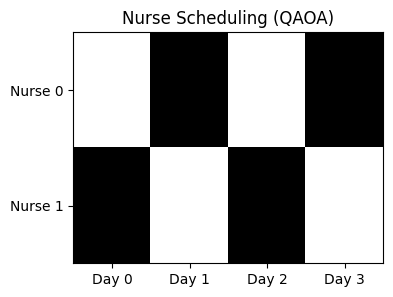

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Given list of tuples (nurse, day)
data = assigned_days #[(0, 1), (0, 3), (1, 0), (1, 2)]

# Create a grid (default: 0 for no shift)
schedule_grid = np.zeros((num_nurses, num_days))

# Fill the grid (1 for assigned shifts)
for nurse, day in data:
    schedule_grid[nurse, day] = 1  # Mark assigned shifts

# Plot the grid
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(schedule_grid, cmap="Greys", aspect="auto")

# Add labels
ax.set_xticks(np.arange(num_days))
ax.set_yticks(np.arange(num_nurses))
ax.set_xticklabels([f"Day {i}" for i in range(num_days)])
ax.set_yticklabels([f"Nurse {i}" for i in range(num_nurses)])

plt.title("Nurse Scheduling (QAOA)")
plt.show()


# Version Infomation 

In [19]:
import sys
import platform
import qiskit
import docplex
import qiskit_optimization
import qiskit_algorithms

print("="*10 + " Version Information " + "="*10)
print(f"Python              : {sys.version}")
print(f"Operating System    : {platform.system()} {platform.release()} ({platform.architecture()[0]})")
print("="*41)
print(f"Qiskit              : {qiskit.__version__}")
print(f"qiskit_optimization : {qiskit_optimization.__version__} ")
print(f"qiskit_algorithms   : {qiskit_algorithms.__version__} ")
print(f"Cplex               : {docplex.__version__}")
print("="*41)


========== Version Information ==========
Python              : 3.11.11 (main, Dec 11 2024, 10:28:39) [Clang 14.0.6 ]
Operating System    : Darwin 24.3.0 (64bit)
Qiskit              : 1.3.2
qiskit_optimization : 0.6.1 
qiskit_algorithms   : 0.3.1 
Cplex               : 2.29.241


# Reference 

[1]. [D Wave examples - Nurse Scheduling](https://cloud.dwavesys.com/leap/examples/254188327)

[2]. [A Brief Study of the Nurse Scheduling
Problem (NSP)](https://arxiv.org/pdf/1902.01193)

[3]. [[PDF] SOLVING NURSE SCHEDULING PROBLEM USING CONSTRAINT PROGRAMMING TECHIQUE](https://www.math.cmu.edu/~af1p/Teaching/OR2/Projects/P23/ORProject_Final_Copy.pdf?utm_source=chatgpt.com)

[4]. [Nurse Scheduling Problem via PyQUBO](https://arxiv.org/abs/2302.09459?utm_source=chatgpt.com)